In [220]:
from sklearn.datasets import make_classification
from imblearn.under_sampling import CondensedNearestNeighbour
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import fetch_mldata
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy
import sklearn.metrics
from matplotlib.colors import ListedColormap
import pandas as pd

In [269]:
weights=[0.2, 0.05, 0.05, 0.7]
def generate_dataset():
    X, Y =  make_classification(n_samples=250, n_features=2, n_informative=2, n_redundant=0, n_repeated=0, n_classes=4, 
                    n_clusters_per_class=1, class_sep=0.9, hypercube=True,
                    shuffle=True)
    print ("Initial class")
    print(numpy.bincount(Y))
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y)
    print ("Y_train set up:")
    print(numpy.bincount(Y_train))
    return X_train, X_test, Y_train, Y_test

In [270]:
red = '#e6194b'
light_red = '#FF91A4'
dark_red = '#E23D28'
green = '#3cb44b'
light_green = '#98FB98'
dark_green = '#00563B'
blue = '#0082c8'
light_blue = '#87CEEB'
dark_blue = '#000080'
yellow = '#ffe119'
light_yellow = '#FFFF66'
dark_yellow = '#666600'

In [271]:
def map_color(x):
    if x==0:
        return red
    if x==1:
        return green
    if x==2:
        return blue
    else:
        return yellow

def map_light_color(x):
    if x==0:
        return light_red
    if x==1:
        return light_green
    if x==2:
        return light_blue
    else:
        return light_yellow
    
def map_dark_color(x):
    if x==0:
        return dark_red
    if x==1:
        return dark_green
    if x==2:
        return dark_blue
    else:
        return dark_yellow

In [272]:
def calculate_plot_limits(X_train, X_test):
    first_feature = X_train[:, 0]
    x_min, x_max = first_feature.min(), first_feature.max()
    
    x_test_min, x_test_max = X_test[:, 0].min(), X_test[:, 0].max()
    
    x_min = min(x_min, x_test_min)
    x_max = max(x_max, x_test_max)
    
    second_feature = X_train[:, 1]
    y_min, y_max = second_feature.min(), second_feature.max()
    
    y_test_min, y_test_max = X_test[:, 1].min(), X_test[:, 1].max()
    
    y_min = min(y_min, y_test_min)
    y_max = max(y_max, y_test_max)
    
    return x_min, x_max, y_min, y_max

In [277]:
# TODO: generate latex table :)
def run_experiment(X_train, X_test, Y_train, Y_test, classifier, neighbours_number):
    experiment_result = {}
    first_feature = X_train[:, 0]
    second_feature = X_train[:, 1]
    # we wanna plot cnn training set before compression to compare
    if classifier == 'cnn':
        fig = plt.figure(figsize=(7,7))
        ax = fig.gca()
        ax.set_autoscale_on(False)
        map_color_numpy = numpy.vectorize(lambda x: map_color(x))
        color_map = map_color_numpy(Y_train)
        plt.scatter(first_feature, second_feature, c=color_map)
        ax.axis([-4,4,-4,4])
        plt.title('CNN ' + str(neighbours_number) + " training set")
        plt.show()

    if classifier == 'cnn':
        knn = CondensedNearestNeighbour(n_neighbors=neighbours_number)
    else:
        knn = KNeighborsClassifier(n_neighbors=neighbours_number)

    if classifier == 'cnn':    
        X_res, labels = knn.fit_sample(X_train, Y_train)
        print ("affter compression")
        print (numpy.bincount(labels))
        init_train_size = (len(X_train))
        x_res = X_res[:, 0]
        y_res = X_res[:, 1]
        fig = plt.figure(figsize=(7,7))
        ax = fig.gca()
        ax.set_autoscale_on(False)
        map_color_numpy = numpy.vectorize(lambda x: map_color(x))
        color_map = map_color_numpy(labels)
        plt.scatter(x_res, y_res, c=color_map)
        ax.axis([-4,4,-4,4])
        plt.title('CNN ' + str(neighbours_number) + " training set after compression")
        plt.show()
        knn = KNeighborsClassifier(n_neighbors=neighbours_number)
        X_train = X_res
        first_feature = X_train[:, 0]
        second_feature = X_train[:, 1]
        Y_train = labels
        experiment_result['compression_rate'] = len(X_res)/init_train_size
    
    knn.fit(X_train, Y_train)
    Y_predicted = knn.predict(X_test)
    
    experiment_result['accuracy'] = sklearn.metrics.accuracy_score(Y_test, Y_predicted)
    experiment_result['classification_report'] = sklearn.metrics.classification_report(Y_test, Y_predicted)
    #############################################################
    x_min, x_max, y_min, y_max = calculate_plot_limits(X_train, X_test)
   

    cmap_light = ListedColormap([light_red, light_green, light_blue, light_yellow])
    cmap_normal = ListedColormap([red, green, blue, yellow])
    
    # plot decision boundary
    h = 0.01
    xx, yy = numpy.meshgrid(
        numpy.arange(-4, 4, h), 
        numpy.arange(-4, 4, h))
    Z = knn.predict(numpy.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    fig = plt.figure(figsize=(8,8))
    ax = fig.gca()
    ax.set_autoscale_on(False)
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)
     
    cmap_light_vectorize = numpy.vectorize(lambda x: map_color(x))
    col = cmap_light_vectorize(Y_train)
    
    cmap_bold_vectorize = numpy.vectorize(lambda x: map_dark_color(x))
    col_test = cmap_bold_vectorize(Y_test)
    
    edge_colors_vectorize = numpy.vectorize(lambda x: map_color_bold(x))
    edge_colors = edge_colors_vectorize(Y_train)

    plt.scatter(first_feature, second_feature, c=col, marker='o', s=30, alpha=1,
            edgecolors=edge_colors, linewidths=1) # plot train data
    plt.scatter(X_test[:, 0], X_test[:, 1], c=col_test, marker='x', s=30, edgecolors='black') # plot test data
    ax.axis([-4,4,-4,4])
    plt.title(classifier + " " + str(neighbours_number))

    plt.show()
    return experiment_result

In [278]:
def generate_latex_code_for_result(experiment_result):
    print (experiment_result.get('compression_rate'))
    print (experiment_result['accuracy'])
    print (experiment_result['classification_report'])

In [280]:
X_train, X_test, Y_train, Y_test = generate_dataset()

Initial class
[62 63 62 63]
Y_train set up:
[45 50 48 44]


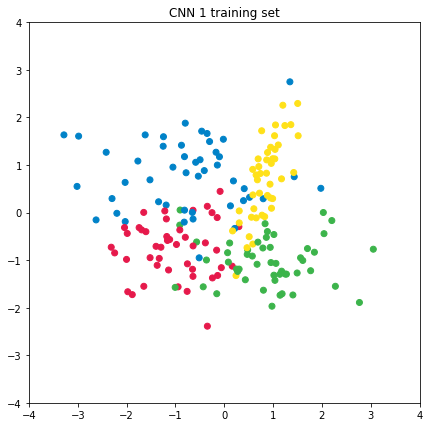

affter compression
[ 6 13  8 44]


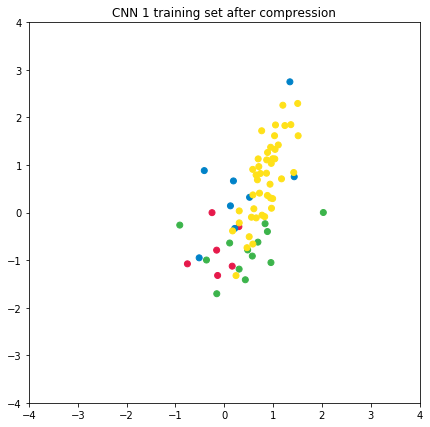

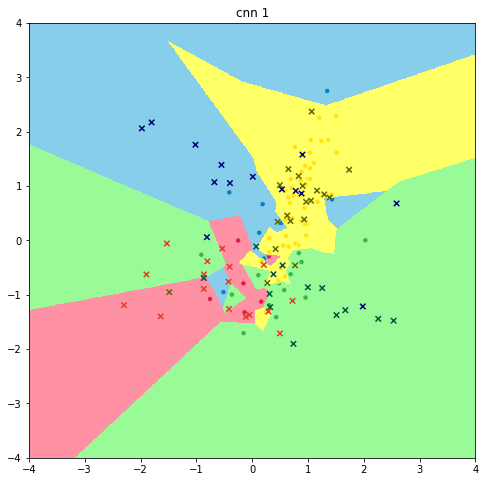

0.37967914438502676
0.603174603175
             precision    recall  f1-score   support

          0       0.78      0.41      0.54        17
          1       0.45      0.69      0.55        13
          2       0.70      0.50      0.58        14
          3       0.62      0.79      0.70        19

avg / total       0.65      0.60      0.60        63



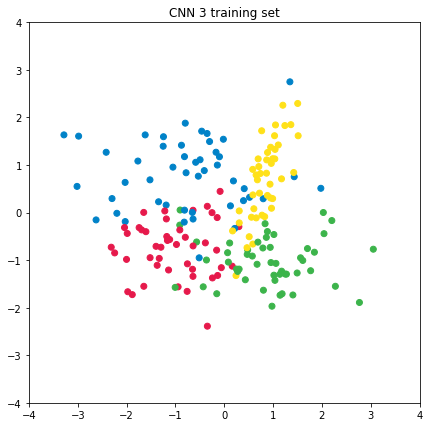

affter compression
[ 8 15 11 44]


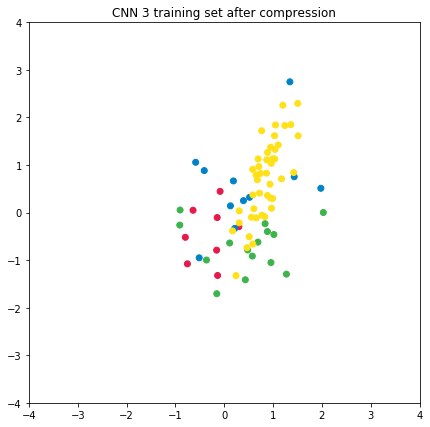

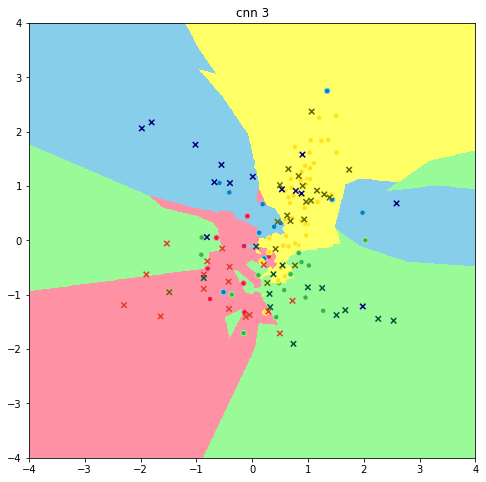

0.41711229946524064
0.698412698413
             precision    recall  f1-score   support

          0       0.80      0.71      0.75        17
          1       0.50      0.69      0.58        13
          2       0.89      0.57      0.70        14
          3       0.71      0.79      0.75        19

avg / total       0.73      0.70      0.70        63



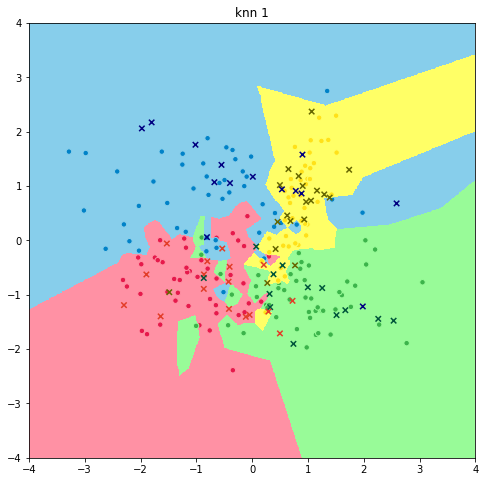

None
0.714285714286
             precision    recall  f1-score   support

          0       0.80      0.71      0.75        17
          1       0.69      0.69      0.69        13
          2       0.75      0.64      0.69        14
          3       0.65      0.79      0.71        19

avg / total       0.72      0.71      0.71        63



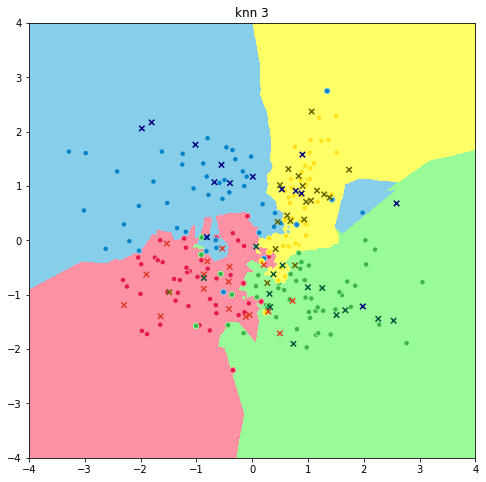

None
0.714285714286
             precision    recall  f1-score   support

          0       0.81      0.76      0.79        17
          1       0.56      0.69      0.62        13
          2       0.80      0.57      0.67        14
          3       0.71      0.79      0.75        19

avg / total       0.73      0.71      0.72        63



In [281]:
classifiers = ['cnn', 'knn']
neighbours_numbers = [1, 3]
for classifier in classifiers:
    for neighbours_number in neighbours_numbers:
        experiment_result = run_experiment(X_train, X_test, Y_train, Y_test, classifier, neighbours_number)
        generate_latex_code_for_result(experiment_result)
        